In [2]:
import overlay_data_on_position 
from overlay_data_on_position import * 
from overlay_data_on_position import plot_network_communities 
from overlay_data_on_position import plot_data_on_video 
import voronoi_graphs
from utilities import create_colourlist
import imgstore
import networkx as nx
from overlay_data_on_position import plot_data_on_video    
from mpl_toolkits.axes_grid1 import make_axes_locatable
from local_properties import sync_rotation  
import stim_handling as stims 

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
def drop_bad_points(fbf, arena_centre=(160.0,160.0)):
    fbf['radius'] = np.sqrt((fbf[XPOS]-arena_centre[0])**2 + (fbf[YPOS]-arena_centre[1])**2) 
    fbf = fbf.loc[fbf['radius'] <215, :]
    fbf = fbf.loc[fbf[XPOS] < 315,:]  #FIXME hardcoding bad
    return fbf

def sync_by_stimStart(df, ID, col='speed'):
    """
    pass a df with stim information
    returns the df with rotation values adjusted for direction so rotation of new stim is positive
    """
    df = df.sort_values('Time')
    df.reset_index(inplace=True)
    df = df[:-10] #drop end to avoid dealing with annoying NaN cases #lazy #FIXME
    
    df.loc[:,'stimStart'] = 0
    firstStim = df.loc[df['Time'] < df['Time'].median(), 'speed'].idxmax()
    df.loc[firstStim, 'stimStart'] = 1
    df.loc[:,'stimEnd'] = 0
    lastStim = df.loc[df['Time'] > df['Time'].median(), 'speed'].idxmin()
    df.loc[lastStim, 'stimEnd'] = 1
    
    alignPoints = list(df[df['stimStart'] == 1]['Timestamp'].values)
    #df = df[df[col].isnull() == False]
    i = alignPoints[0]
    df['syncTime'] = pd.to_timedelta(df['Timestamp']-i,'s') 
    df['trialID'] = ID
    DIRECTION = np.sign(np.median(df['dir']))
    df[df.columns[['otation' in f for f in df.columns]]] *= DIRECTION
    
    return df

def sync_by_reversal(df, ID, col='dir'):
    """
    pass a df with stim information
    returns the df with rotation values adjusted for direction so rotation of new stim is positive
    """
    df = df[df[col] != '--'] #lazy solution
    df = df.sort_values('Timestamp').reset_index()
    df = df[:-10]
    df['reversal'] = 0
    df[col] = df[col].astype(float)
    reversals = df[abs(df[col] - df.shift()[col]) ==2].index
    df.loc[reversals, 'reversal'] = 1
    df.loc[df['Time'] > 300, 'reversal'] = 0 #FIXME this is a hack solution to sort out ends
    df['firstStim'] = 0
    firstStim = df[df['Time'] < df['Time'].median()]
    firstStim = firstStim[abs(firstStim[col] - firstStim.shift()[col]) ==1].index
    df.loc[firstStim, 'firstStim'] = 1
    df['lastStim'] = 0
    lastStim = df[df['Time'] > df['Time'].median()]
    lastStim = lastStim[abs(lastStim[col] - lastStim.shift()[col]) ==1].index
    df.loc[lastStim, 'lastStim'] = 1
    trials = pd.DataFrame()
    trialID = 0    
    alignPoints = list(df[df['reversal'] == 1]['Timestamp'].values)
    for i in alignPoints:
        data = df.loc[df['Timestamp'].between(i-10.0, i+60.0), :]
        data['syncTime'] = pd.to_timedelta(data['Timestamp']-i,'s') 
        data['trialID'] = ID + '_' + str(trialID)
        data['date'] = ID.split('_')[0]
        DIRECTION = np.sign(np.median(data['dir']))
        data[data.columns[['otation' in f for f in data.columns]]] *= DIRECTION
        trialID += 1
        trials = pd.concat([trials, data], axis=0)        
    return trials


def rank_on_column(df, col, nRanks):
    """
    pass a df, returns an index-matched series grouping col into nRanks groups
    """
    bounds = np.linspace(0,1,nRanks+1)
    df = df.copy()
    df['rank'] = np.nan
    for i in range(nRanks):
        if i == 0:
            INKL=True
        else:
            INKL=False
        df.loc[df[col].between(df.quantile(bounds[i])[col], 
                               df.quantile(bounds[i+1])[col] + 1e5, #tiny hack for inclusive upper bound
                               inclusive=INKL),
              'rank'] = i
    return df['rank']


def get_prestim_area(fbf):
    g = fbf.groupby('FrameNumber')
    areaDF = get_hull_area(g)
    return areaDF



In [4]:
MAIN_DIR = '/media/recnodes/recnode_2mfish/reversals3m_128_dotbot_20181106_145202.stitched/'
expID = MAIN_DIR.split('/')[-2].split('.')[0]
exp, groupsize, _, trialID = expID.split('_', 3)
local = pd.read_pickle(MAIN_DIR + 'track/localData_FBF.pickle')
store = imgstore.new_for_filename(MAIN_DIR +'metadata.yaml')
fbf = pd.read_pickle(MAIN_DIR+'/track/frameByFrameData.pickle') 
if len(fbf) < 1000:
    fbf = joblib.load(MAIN_DIR+'/track/frameByFrameData.pickle') 

ret, fbf = stims.sync_data(fbf, 
                    stims.get_logfile(MAIN_DIR), 
                    store) 

foo = fbf.groupby('trackid').max()['BORDER_DISTANCE#wcentroid']#scrubadubdub
fbf = fbf[~(fbf.trackid.isin(foo[foo<50].index))]#scrubadubdub

#dtypes must match before merge
for col in ['trackid','frame']:
    for df in [local,fbf]:
        df[col] = df[col].astype(int)
fbf = fbf.merge(local)
fbf = drop_bad_points(fbf)  #scrubadubdub
if 'coherence' in expID:   
    synced = sync_by_stimStart(fbf.copy(), trialID)                             
elif 'reversal' in expID:
    synced = sync_by_reversal(fbf.copy(), trialID)



/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWit

In [5]:
expID

'reversals3m_128_dotbot_20181106_145202'

In [6]:
prestim = synced[synced.syncTime.between(np.timedelta64(-10, 's'), np.timedelta64(0,'s'))]

In [7]:
prestim

,index,ACCELERATION#smooth#wcentroid,ANGULAR_A#wcentroid,ANGULAR_V#wcentroid,AX#smooth#wcentroid,AY#smooth#wcentroid,BORDER_DISTANCE#wcentroid,SPEED#smooth#wcentroid,VX#smooth#wcentroid,VY#smooth#wcentroid,...,localPolarization,localPDcor,localSpeedScore,radius,reversal,firstStim,lastStim,syncTime,trialID,date
429671,429746,1.980302,-5.221651,-0.134613,-0.785304,1.817937,129.729050,21.481541,12.347111,17.578550,...,0.940604,-0.428571,0.666667,51.258168,0,0,0,-1 days +23:59:50.009980,20181106_145202_0,20181106
429672,429754,75.916656,151.531708,4.051303,60.773899,45.495850,115.633636,29.476301,19.298805,22.280226,...,0.930356,0.200000,1.000000,68.025765,0,0,0,-1 days +23:59:50.009980,20181106_145202_0,20181106
429673,429744,74.936356,-21.861670,-2.218971,64.081993,38.845268,126.149773,11.063836,-8.008852,-7.633267,...,0.995241,0.300000,0.000000,38.715933,0,0,0,-1 days +23:59:50.009980,20181106_145202_0,20181106
429674,429745,21.789993,0.000000,0.000000,-13.672921,-16.966291,20.954781,0.536091,-0.467554,-0.262273,...,1.000000,NaN,NaN,140.316908,0,0,0,-1 days +23:59:50.009980,20181106_145202_0,20181106
429675,429747,10.127155,-25.327589,3.526643,7.685604,-6.594753,105.745377,27.172029,-25.316309,-9.869334,...,0.927933,0.214286,1.000000,56.035006,0,0,0,-1 days +23:59:50.009980,20181106_145202_0,20181106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1068128,1068048,8.760919,-3.842189,-0.186625,-1.716950,-8.591028,48.732189,26.722092,-8.950637,-25.178488,...,0.568688,-0.800000,0.750000,113.262113,0,0,0,00:00:00,20181106_145202_2,20181106
1068129,1068056,73.676064,5.061217,-1.814417,-65.397118,-33.931976,134.398972,7.248629,6.460148,3.287721,...,0.714328,0.023810,0.250000,41.413968,0,0,0,00:00:00,20181106_145202_2,20181106
1068130,1068046,62.677395,13.375717,2.766114,-60.252193,-17.266415,133.664276,13.147767,-12.945570,-2.296957,...,0.819280,-0.257143,1.000000,26.618692,0,0,0,00:00:00,20181106_145202_2,20181106
1068131,1068045,24.736998,58.285183,-1.730033,15.922853,-18.930975,132.391357,10.230673,-7.867769,6.539486,...,0.953652,-0.600000,0.200000,28.727798,0,0,0,00:00:00,20181106_145202_2,20181106


local = pd.read_pickle('/media/recnodes/recnode_2mfish/reversals3m_128_dotbot_20181211_151201.stitched/track/localData_FBF.pickle' )


In [9]:
for group, data in prestim.groupby('trialID'):
                s = pd.Series(data.median(), name=group)#get_prestim_area(data)
                s['exp'] = exp
                s['groupsize'] = groupsize
                results = results.append(s)
                results.to_pickle('/media/recnodes/Dan_storage/20200407_prestim_local_measures.pickle')    


NameError: name 'results' is not defined

In [10]:
local = sync_rotation(local, stims.get_logfile(MAIN_DIR), store)
local['trackid'] = local['trackid'].astype(float).astype(int)
local['Time'] = local.loc[:,'Timestamp'] - local.iloc[0]['Timestamp']

cols = ['objIDcol', 'EigenCen', 'comm_EigenCen', 'localArea',
       'comm_R', 'R', 'localMedianRotation', 'localRscore',
       'localPackingFraction', 'localPolarization', 'localPScore', 'localSpeedScore']

cMin = [ 0, 0, 0.0, 0, 0,
        -1.0, -1.0, -1.0, 0,
        0, 0, 0, 0]


In [11]:
local.shape

(2479637, 20)

In [12]:
list(local.columns)

['frame',
 'trackid',
 'neighbourDist',
 'localArea',
 'localPackingFraction',
 'localMedianRotation',
 'localRscore',
 'localPolarization',
 'localPDcor',
 'localSpeedScore',
 'FrameNumber',
 'Timestamp',
 'IP',
 'nDots',
 'dotSize',
 'speed',
 'dir',
 'coh',
 'comment',
 'Time']

In [13]:
fbf.columns

Index(['ACCELERATION#smooth#wcentroid', 'ANGULAR_A#wcentroid',
       'ANGULAR_V#wcentroid', 'AX#smooth#wcentroid', 'AY#smooth#wcentroid',
       'BORDER_DISTANCE#wcentroid', 'SPEED#smooth#wcentroid',
       'VX#smooth#wcentroid', 'VY#smooth#wcentroid', 'X#wcentroid',
       'Y#wcentroid', 'frame', 'time', 'trackid', 'uVX', 'uVY', 'coreGroup',
       'rotation_cMass', 'rotation_cArea', 'FrameNumber', 'Timestamp', 'IP',
       'nDots', 'dotSize', 'speed', 'dir', 'coh', 'comment', 'coherence',
       'Time', 'neighbourDist', 'localArea', 'localPackingFraction',
       'localMedianRotation', 'localRscore', 'localPolarization', 'localPDcor',
       'localSpeedScore', 'radius'],
      dtype='object')

In [1]:
def compile_alldata(handle):
    allData = pd.DataFrame()

    for groupsize in groupsizes:
        print(groupsize)
        groupData = pd.DataFrame()
        for fn in glob.glob('/media/recnodes/recnode_2mfish/'+ handle +'_' + str(groupsize) + '_dotbot_*/track/localData_FBF.pickle'):
            #if '20181026' in fn:#day when fish were left in the tank overnight
            #    continue
            if '20190523' in fn:#on this day, timestamps were out of sync by ~25 seconds
                continue
            if '20190603' in fn:#on this day, timestamps were out of sync by ~25 seconds
                continue
            print(fn)
            try:
                pf = pd.read_pickle(fn)
                if not 'FrameNumber' in pf.columns:
                    if not 'frame' in pf.columns:
                        pf['frame'] = pf.index.copy()           
                    ret, pf = stims.sync_reversals(pf, stims.get_logfile(fn.rsplit('/',2)[0]), imgstore.new_for_filename(fn.rsplit('/',2)[0] + '/metadata.yaml'))
            except Exception as e:
                print("failed for ", fn)
                print(e)
                continue
            pf['dir'] = pd.to_numeric(pf['dir'], errors='coerce')
            
            ID = fn.split('_dotbot')[1].split('.')[0]

            reversals = sync_by_reversal(pf, ID)
            #fileID = fn.split('/')[-3].split('.')[0].split('_',3)[-1]
            #reversals = align_by_stim(pf, fileID)
            if len(reversals) == 0:
                continue
            reversals['groupsize'] = groupsize

            groupData = pd.concat([groupData, reversals], axis=0)
        groupData.to_pickle('/media/recnodes/Dan_storage/20200708_reversal_localdata_compiled_' + str(groupsize) + '.pickle')

        allData = pd.concat([allData, groupData], axis=0)
    allData.to_pickle('/media/recnodes/Dan_storage/20200708_reversal_localdata_compiled_full.pickle')

In [53]:
def plot_data_vs_R(trials, col='localPolarization', grouping='trialID', plotTrials=False, 
                     fig= None, ax=None, colour=None, XLIM=(-1.05,1.05), YLIM='auto',
                     RESAMPLE='250ms', NORMALIZE_PRESTIM=False, 
                     XLABEL='Rotation order', YLABEL='undefined'):
    #colourList = ['#EA4335','#E16D13','#FBBC05','#34A853','#4285F4','#891185',
    #              '#4285F4','#FBBC05','#34A853','#EA4335','#891185','#E16D13','#0B1C2E','#347598']

    trials.index = trials.syncTime

    if YLIM == 'auto':
        foo = trials.copy()
        YLIM = getMinMax(foo.resample(RESAMPLE).mean().groupby([grouping,'syncTime']).mean()[col], buffer=0.1)

    if fig== None:
        fig = plt.figure()
        ax = fig.add_subplot(111) 
    if grouping == 'trialID': 
        g = trials.groupby(grouping)
        LW = 0.5
        ALPHA = 0.5
        for a, data in g:
            #data.index = data['syncTime']
            data = data.resample(RESAMPLE).mean()
            ax.plot(data['median_dRotation_cArea'], data[col], label=str(a), linewidth=LW, alpha=ALPHA)

    else:
        g = trials.groupby([grouping])
        LW = 0.5
        ALPHA = 0.5
        groupCount = 0
        for group, data in g:
            if grouping == 'coh':
                if not group in [0,0.2,0.4,0.6,0.8,1.0]:
                    continue
            N = len(set(data['trialID']))
            LABEL = str(group) + ', N=' + str(int(N))
            if plotTrials == True:
                h = data.groupby('trialID')
                for a, vals in h:
                    ax.plot(vals['median_dRotation_cArea'], vals[col], label=LABEL, 
                                                    linewidth=LW, 
                                                    alpha=ALPHA, 
                                                    color=colourList[groupCount])
                    LABEL = '_nolegend_'
            data.index = data['syncTime']
            r = data.resample(RESAMPLE).mean()
            sem = 1.253*(data.resample(RESAMPLE).std()/np.sqrt(N)) #http://davidmlane.com/hyperstat/A106993.html and
            #    https://influentialpoints.com/Training/standard_error_of_median.htm
            #xvals = [i.total_seconds()  for i in r.index]
            #prestimIdx = (np.array(xvals) < 0) * (np.array(xvals)>-1)
            #if NORMALIZE_PRESTIM:
            #    a = r.loc[prestimIdx, col].mean() #normalization value for variation in prestim
            #else:
            a=0
            ax.plot(r['median_dRotation_cArea'], r[col]-a, label=LABEL, linewidth=2, color=colourList[groupCount], zorder=100)
            ax.fill_between(r['median_dRotation_cArea'], 
                            r[col]-a+sem[col], 
                            r[col]-a-sem[col], 
                            color=colourList[groupCount], 
                            alpha=0.1, 
                            linewidth=0,
                            zorder=10)
            groupCount+=1

    #fig.autofmt_xdate()
    ax.set_xlabel('Rotation order')#, fontsize='xx-small')

    
    if YLABEL== 'undefined':
        ax.set_ylabel(col)#, fontsize='xx-small')
    else:
        ax.set_ylabel(YLABEL)#, fontsize='xx-small')
    ax.set_ylim(YLIM[0], YLIM[1])
    #ax.set_yticks([-1.0, 0, 1.0])
    ax.set_xlim(XLIM[0], XLIM[1])
    if grouping == 'coh':
        plt.legend(title='Coherence', fontsize='xx-small')
    else:
        plt.legend(title=grouping, fontsize='xx-small')
    #plotnice()
    return fig

In [16]:
def getMinMax(series, buffer=0.05):
    MIN = series.min()
    if MIN < 0: 
        MIN*= 1.0 + buffer
    else:
        MIN*=1.0 - buffer
    if series.max() < 0:
        MAX = series.max() *(1.0-buffer)
    else:
        MAX = series.max() *(1.0+buffer)
    return (MIN, MAX)

In [62]:
def plot_many_trials(trials, col='median_dRotation_cArea', grouping='trialID', plotTrials=True, 
                     fig= None, ax=None, colour=None, XLIM=(-10,60), YLIM=(-1.05,1.05), 
                     RESAMPLE='250ms', NORMALIZE_PRESTIM=False, 
                     YLABEL='Mean congruent rotation order $\pm$ SEM'):
    #colourList = ['#EA4335','#E16D13','#FBBC05','#34A853','#4285F4','#891185',
    #              '#4285F4','#FBBC05','#34A853','#EA4335','#891185','#E16D13','#0B1C2E','#347598']
    colourList = create_colourlist(len(set(trials[grouping])), cmap='viridis')
    trials.index = trials.syncTime

    if YLIM == 'auto':
        foo = trials.copy()
        YLIM = getMinMax(foo.resample(RESAMPLE).mean().groupby([grouping,'syncTime']).mean()[col], buffer=0.1)

    if fig== None:
        fig = plt.figure()
        ax = fig.add_subplot(111) 
    if grouping == 'trialID': 
        g = trials.groupby(grouping)
        LW = 0.5
        ALPHA = 0.5
        for a, data in g:
            #data.index = data['syncTime']
            data = data.resample(RESAMPLE).mean()
            ax.plot(data.index, data[col], label=str(a), linewidth=LW, alpha=ALPHA)
    elif grouping == 'byday': 
        g = trials.groupby(['date'])
        LW = 0.5
        ALPHA = 0.5
        groupCount = 0
        for date, data in g:
            h = data.groupby('trialID')
            LABEL = date
            for a, vals in h:
                vals = vals.resample(RESAMPLE).mean()
                xvals = [t.total_seconds() for t in vals.index]
                ax.plot(xvals, vals[col], label=LABEL, 
                                                linewidth=LW, 
                                                alpha=ALPHA, 
                                                color=colourList[groupCount])
                LABEL = '_nolegend_'
            groupCount += 1
    else:
        g = trials.groupby([grouping])
        LW = 0.5
        ALPHA = 0.5
        groupCount = 0
        for group, data in g:
            if grouping == 'coh':
                if not group in [0,0.2,0.4,0.6,0.8,1.0]:
                    continue
            N = len(set(data['trialID']))
            LABEL = str(group) + ', N=' + str(int(N))
            if plotTrials == True:
                h = data.groupby('trialID')
                for a, vals in h:
                    ax.plot(vals.index, vals[col], label=LABEL, 
                                                    linewidth=LW, 
                                                    alpha=ALPHA, 
                                                    color=colourList[groupCount])
                    LABEL = '_nolegend_'
            data.index = data['syncTime']
            r = data.resample(RESAMPLE).mean()
            sem = 1.253*(data.resample(RESAMPLE).std()/np.sqrt(N)) #http://davidmlane.com/hyperstat/A106993.html and
            #    https://influentialpoints.com/Training/standard_error_of_median.htm
            xvals = [i.total_seconds()  for i in r.index]
            prestimIdx = (np.array(xvals) < 0) * (np.array(xvals)>-1)
            if NORMALIZE_PRESTIM:
                a = r.loc[prestimIdx, col].mean() #normalization value for variation in prestim
            else:
                a=0
            ax.plot(xvals, r[col]-a, label=LABEL, linewidth=2, color=colourList[groupCount], zorder=100)
            ax.fill_between(xvals, 
                            r[col]-a+sem[col], 
                            r[col]-a-sem[col], 
                            color=colourList[groupCount], 
                            alpha=0.1, 
                            linewidth=0,
                            zorder=10)
            groupCount+=1

    #fig.autofmt_xdate()
    ax.set_xlabel('Time since direction change (s)')#, fontsize='xx-small')

    
    if NORMALIZE_PRESTIM:
        ax.set_ylabel('Normalized ' + YLABEL)#, fontsize='xx-small')
    else:
        ax.set_ylabel(YLABEL)#, fontsize='xx-small')
    ax.set_ylim(YLIM[0], YLIM[1])
    #ax.set_yticks([-1.0, 0, 1.0])
    ax.set_xlim(XLIM[0], XLIM[1])
    if grouping == 'coh':
        plt.legend(title='Coherence', fontsize='xx-small')
    else:
        plt.legend(title=grouping, fontsize='xx-small')
    #plotnice()
    return fig

In [18]:
groupingdf = pd.read_pickle('/media/recnodes/Dan_storage/reversals3m_prestim_local_measures_complete.pickle')

In [19]:
groupingdf

,ACCELERATION#smooth#wcentroid,ANGULAR_A#wcentroid,ANGULAR_V#wcentroid,AX#smooth#wcentroid,AY#smooth#wcentroid,BORDER_DISTANCE#wcentroid,SPEED#smooth#wcentroid,Time,Timestamp,VX#smooth#wcentroid,...,time,trackid,trialID,uVX,uVY,header,Packing_rank,NeighbourDist_rank,localPolarization_rank,PDcor_rank
20190603_165201_0,17.042793,-0.026260,-0.010011,-0.067161,0.103869,64.792091,7.713285,93.265216,1.559574e+09,-0.202100,...,93.265213,280.0,2.019060e+14,-0.041159,-0.081201,NaN,0.0,2.0,0.0,0.0
20190603_165201_1,14.982355,-0.009627,0.009723,0.139627,-0.234806,72.976673,6.579251,153.279318,1.559574e+09,-0.411552,...,153.279312,286.0,2.019060e+14,-0.087646,0.111978,NaN,0.0,2.0,0.0,0.0
20190603_165201_2,17.383579,0.084555,-0.007636,-0.312178,-0.164991,63.517334,8.111867,273.332459,1.559574e+09,0.713339,...,273.332458,284.0,2.019060e+14,0.115792,0.214113,NaN,0.0,2.0,0.0,0.0
20181024_153201_0,30.337879,0.180438,-0.164845,-0.081354,0.056583,108.765652,19.112821,91.882387,1.540388e+09,1.252040,...,92.907036,35.0,2.018102e+14,0.125595,-0.130695,NaN,0.0,2.0,1.0,0.0
20181024_153201_1,29.575075,-0.170044,0.124957,0.070311,-0.338197,105.104031,17.472138,151.922344,1.540388e+09,-1.082216,...,152.946991,37.0,2.018102e+14,-0.136244,0.048075,NaN,0.0,2.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20181017_131202_1,36.820641,0.000000,-0.070650,0.000946,0.451901,56.170433,20.383619,210.889480,1.539775e+09,-0.718552,...,212.962418,284.0,2.018102e+14,-0.118024,-0.040382,NaN,0.0,2.0,1.0,0.0
20181017_131202_2,33.087162,0.000000,0.037574,-0.008243,-0.051176,68.569695,16.634268,270.929498,1.539775e+09,-0.225307,...,273.002441,280.0,2.018102e+14,-0.065148,0.026166,NaN,1.0,1.0,0.0,0.0
20191119_133201_0,25.508089,0.000000,0.084694,-0.031209,-0.426150,117.037964,10.379659,53.496793,1.574167e+09,0.000000,...,93.502586,287.0,2.019112e+14,-0.002156,0.213741,NaN,2.0,0.0,1.0,0.0
20191119_133201_1,26.287346,0.000000,-0.087159,-0.221163,-0.011998,113.659241,10.556639,113.408751,1.574167e+09,0.722953,...,153.414536,283.0,2.019112e+14,0.095862,0.052573,NaN,2.0,0.0,1.0,0.0


#using groupingdf, we can sort trials by their prestim conditions.

#from there, we should be able to use some variant of plot_many_trials
# to plot the data grouped in different ways



In [20]:
groupsizes = [64,128,256,512]#,1024]
colourList = create_colourlist(len(groupsizes), cmap='viridis')

In [21]:
revdata = pd.read_pickle('/media/recnodes/Dan_storage/20200203_reversal_data_compiled_full.pickle')

In [36]:
revdata['frame'] = revdata.index

In [23]:
import glob
import os
import joblib

allLocaldata = compile_alldata('reversals3m')

64
/media/recnodes/recnode_2mfish/reversals3m_64_dotbot_20181024_153201.stitched/track/localData_FBF.pickle


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWit

/media/recnodes/recnode_2mfish/reversals3m_64_dotbot_20190529_155202.stitched/track/localData_FBF.pickle


/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:1236: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  clsname = yaml.load(f)[STORE_MD_KEY]['class']
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/imgstore/stores.py:171: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  allmd = yaml.load(f)
previous store had incorrect image_shape: corrected (4049, 3866, 3) -> (4048, 3866, 3)
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/home/dan/miniconda3/envs/netstuff/lib/python3.6/site-packages/ipykernel_launcher.py:59: SettingWit

/media/recnodes/recnode_2mfish/reversals3m_64_dotbot_20181113_103201.stitched/track/localData_FBF.pickle


KeyboardInterrupt: 

In [24]:
allLocaldata = pd.read_pickle('/media/recnodes/Dan_storage/20200407_reversal_localdata_compiled_full.pickle')

In [25]:
allLocaldata.columns

Index(['index', 'frame', 'trackid', 'neighbourDist', 'localArea',
       'localPackingFraction', 'localMedianRotation', 'localRscore',
       'localPolarization', 'localPDcor', 'localSpeedScore', 'FrameNumber',
       'Timestamp', 'IP', 'nDots', 'dotSize', 'speed', 'dir', 'coh', 'comment',
       'Time', 'reversal', 'firstStim', 'lastStim', 'syncTime', 'trialID',
       'date', 'groupsize'],
      dtype='object')

In [26]:
groupingdf.index

Index(['20190603_165201_0', '20190603_165201_1', '20190603_165201_2',
       '20181024_153201_0', '20181024_153201_1', '20181105_115201_0',
       '20181106_161201_0', '20181106_161201_1', '20181106_161201_2',
       '20181012_111202_0',
       ...
       '20191119_131201_0', '20191119_131201_1', '20190603_171201_0',
       '20190603_171201_1', '20181017_131202_0', '20181017_131202_1',
       '20181017_131202_2', '20191119_133201_0', '20191119_133201_1',
       '20191119_133201_2'],
      dtype='object', length=109)

In [27]:
allLocaldata['trialID'] = allLocaldata['trialID'].astype(str)
groupingdf['trialID'] = groupingdf.index

allLocaldata[0:5]

,index,frame,trackid,neighbourDist,localArea,localPackingFraction,localMedianRotation,localRscore,localPolarization,localPDcor,...,coh,comment,Time,reversal,firstStim,lastStim,syncTime,trialID,date,groupsize
221723,204571,3518.0,35.0,26.404158,1933.840221,0.052486,0.997051,0.666667,0.943140,0.142857,...,NaN,NaN,87.83685,0,0,0,-1 days +23:59:50.005082,_20181024_153201_0,,64
221724,204572,3518.0,47.0,19.171949,689.044469,0.126262,0.988901,0.800000,0.954682,-0.300000,...,NaN,NaN,87.83685,0,0,0,-1 days +23:59:50.005082,_20181024_153201_0,,64
221725,204573,3518.0,40.0,19.906204,1030.857818,0.112528,0.882420,0.714286,0.519981,0.535714,...,NaN,NaN,87.83685,0,0,0,-1 days +23:59:50.005082,_20181024_153201_0,,64
221726,204574,3518.0,51.0,33.334493,2241.340855,0.038816,0.994526,0.400000,0.778718,0.500000,...,NaN,NaN,87.83685,0,0,0,-1 days +23:59:50.005082,_20181024_153201_0,,64
221727,204575,3518.0,56.0,38.399963,2904.567629,0.029953,0.997899,0.000000,0.689389,1.000000,...,NaN,NaN,87.83685,0,0,0,-1 days +23:59:50.005082,_20181024_153201_0,,64


In [42]:
allLocaldata.columns

Index(['index', 'frame', 'trackid', 'neighbourDist', 'localArea',
       'localPackingFraction', 'localMedianRotation', 'localRscore',
       'localPolarization', 'localPDcor', 'localSpeedScore', 'FrameNumber',
       'Timestamp', 'IP', 'nDots', 'dotSize', 'speed', 'dir', 'coh', 'comment',
       'Time', 'reversal', 'firstStim', 'lastStim', 'syncTime', 'trialID',
       'date', 'groupsize'],
      dtype='object')

In [28]:
set(groupingdf['trialID'])

{'20181012_095201_0',
 '20181012_095201_1',
 '20181012_101201_0',
 '20181012_101201_1',
 '20181012_103201_0',
 '20181012_103201_1',
 '20181012_105201_0',
 '20181012_105201_1',
 '20181012_111202_0',
 '20181012_111202_1',
 '20181012_115201_0',
 '20181012_115201_1',
 '20181017_131202_0',
 '20181017_131202_1',
 '20181017_131202_2',
 '20181018_151202_0',
 '20181018_151202_1',
 '20181018_155202_0',
 '20181023_111201_0',
 '20181023_111201_1',
 '20181023_111201_2',
 '20181023_113201_0',
 '20181024_141202_0',
 '20181024_141202_1',
 '20181024_143202_0',
 '20181024_151202_0',
 '20181024_151202_1',
 '20181024_153201_0',
 '20181024_153201_1',
 '20181105_105202_0',
 '20181105_105202_1',
 '20181105_111202_0',
 '20181105_111202_1',
 '20181105_111202_2',
 '20181105_115201_0',
 '20181105_121202_0',
 '20181105_121202_1',
 '20181105_121202_2',
 '20181105_121202_3',
 '20181106_145202_0',
 '20181106_145202_1',
 '20181106_145202_2',
 '20181106_151202_0',
 '20181106_151202_1',
 '20181106_153202_0',
 '20181106

In [37]:
revdata.columns

Index(['Timestamp', 'speed', 'dir', 'coh', 'mean_polarization', 'mean_radius',
       'median_radius', 'median_swimSpeed', 'median_dRotation_cArea',
       'median_dRotation_cMass', 'std_dRotation_cArea', 'std_dRotation_cMass',
       'entropy_Ra', 'syncTime', 'trialID', 'date', 'groupsize', 'frame'],
      dtype='object')

In [38]:
ranks = groupingdf[['Packing_rank','NeighbourDist_rank','localPolarization_rank','PDcor_rank','trialID']]



rotrank = revdata.merge(ranks, left_on='trialID',right_on='trialID')
rotrank



#merged = allLocaldata.merge(groupingdf[['Packing_rank','NeighbourDist_rank','localPolarization_rank','PDcor_rank','trialID']], left_on='trialID', right_on='trialID')

,Timestamp,speed,dir,coh,mean_polarization,mean_radius,median_radius,median_swimSpeed,median_dRotation_cArea,median_dRotation_cMass,...,entropy_Ra,syncTime,trialID,date,groupsize,frame,Packing_rank,NeighbourDist_rank,localPolarization_rank,PDcor_rank
0,1.540388e+09,0.03,1.0,1,0.099512,65.427477,62.024834,19.143220,-0.985644,-0.983027,...,1.757748,-1 days +23:59:50.009898,20181024_153201_0,20181024,64,3519,0.0,2.0,1.0,0.0
1,1.540388e+09,0.03,1.0,1,0.093170,67.669210,63.499307,18.579865,-0.983360,-0.977634,...,1.771559,-1 days +23:59:50.034878,20181024_153201_0,20181024,64,3520,0.0,2.0,1.0,0.0
2,1.540388e+09,0.03,1.0,1,0.063857,67.621773,63.421929,18.716015,-0.985716,-0.982040,...,1.739483,-1 days +23:59:50.059852,20181024_153201_0,20181024,64,3521,0.0,2.0,1.0,0.0
3,1.540388e+09,0.03,1.0,1,0.057941,68.519643,64.117915,19.064236,-0.980214,-0.979385,...,1.824634,-1 days +23:59:50.084833,20181024_153201_0,20181024,64,3522,0.0,2.0,1.0,0.0
4,1.540388e+09,0.03,1.0,1,0.084196,68.515536,64.098833,18.039560,-0.983032,-0.981660,...,1.690969,-1 days +23:59:50.109823,20181024_153201_0,20181024,64,3523,0.0,2.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319384,1.574167e+09,0.03,-1.0,1,0.123708,62.136620,61.164020,8.081410,0.945360,0.958732,...,2.814941,00:00:59.889819,20191119_133201_1,20191119,512,9833,2.0,0.0,1.0,0.0
319385,1.574167e+09,0.03,-1.0,1,0.098145,61.646275,60.617627,7.917835,0.943508,0.961531,...,2.842690,00:00:59.911966,20191119_133201_1,20191119,512,9834,2.0,0.0,1.0,0.0
319386,1.574167e+09,0.03,-1.0,1,0.110830,61.740122,60.713244,7.817674,0.938312,0.957142,...,2.889085,00:00:59.934165,20191119_133201_1,20191119,512,9835,2.0,0.0,1.0,0.0
319387,1.574167e+09,0.03,-1.0,1,0.109145,61.389203,60.457266,7.687262,0.938618,0.959257,...,2.875267,00:00:59.956380,20191119_133201_1,20191119,512,9836,2.0,0.0,1.0,0.0


In [39]:
rotrank.columns

Index(['Timestamp', 'speed', 'dir', 'coh', 'mean_polarization', 'mean_radius',
       'median_radius', 'median_swimSpeed', 'median_dRotation_cArea',
       'median_dRotation_cMass', 'std_dRotation_cArea', 'std_dRotation_cMass',
       'entropy_Ra', 'syncTime', 'trialID', 'date', 'groupsize', 'frame',
       'Packing_rank', 'NeighbourDist_rank', 'localPolarization_rank',
       'PDcor_rank'],
      dtype='object')

In [45]:
meanlocal = allLocaldata[['frame','neighbourDist', 'localArea',
       'localPackingFraction', 'localMedianRotation', 'localRscore',
       'localPolarization', 'localPDcor', 'localSpeedScore']].groupby('frame').mean()
meanlocal

,neighbourDist,localArea,localPackingFraction,localMedianRotation,localRscore,localPolarization,localPDcor,localSpeedScore
frame,,,,,,,,
2936.0,14.953792,515.237657,0.262463,0.970825,0.504472,0.895458,-0.012782,0.497163
2937.0,14.780781,506.338125,0.264034,0.966661,0.504135,0.885133,0.000536,0.496931
2938.0,14.685103,501.664401,0.268358,0.966053,0.503224,0.884048,-0.005690,0.503194
2939.0,14.666214,497.486005,0.270282,0.965896,0.499413,0.888274,-0.032617,0.498296
2940.0,14.633933,501.876480,0.267429,0.966088,0.498188,0.891735,-0.008438,0.499917
...,...,...,...,...,...,...,...,...
20307.0,15.823484,564.691199,0.252274,-0.957168,0.494568,0.861330,-0.020053,0.508922
20308.0,15.797032,558.551966,0.249299,-0.948046,0.499050,0.851840,-0.058425,0.511715
20309.0,15.855742,554.671490,0.248719,-0.949997,0.498160,0.853641,-0.072680,0.514225


In [47]:
localrotrank = rotrank.merge(meanlocal,left_on='frame', right_on='frame')

In [48]:
localrotrank

,Timestamp,speed,dir,coh,mean_polarization,mean_radius,median_radius,median_swimSpeed,median_dRotation_cArea,median_dRotation_cMass,...,localPolarization_rank,PDcor_rank,neighbourDist,localArea,localPackingFraction,localMedianRotation,localRscore,localPolarization,localPDcor,localSpeedScore
0,1.540388e+09,0.03,1.0,1,0.099512,65.427477,62.024834,19.143220,-0.985644,-0.983027,...,1.0,0.0,15.711968,646.604826,0.346768,0.877378,0.505018,0.802427,0.014363,0.496782
1,1.540286e+09,0.03,-1.0,NaN,0.117182,52.418146,46.544248,24.853174,-0.978044,-0.985473,...,1.0,0.0,15.711968,646.604826,0.346768,0.877378,0.505018,0.802427,0.014363,0.496782
2,1.541415e+09,0.03,1.0,1,0.095073,71.696101,69.431003,19.060769,-0.961942,-0.967504,...,0.0,0.0,15.711968,646.604826,0.346768,0.877378,0.505018,0.802427,0.014363,0.496782
3,1.541413e+09,0.03,-1.0,1,0.113575,64.620445,55.179713,15.762309,-0.971747,-0.965128,...,0.0,0.0,15.711968,646.604826,0.346768,0.877378,0.505018,0.802427,0.014363,0.496782
4,1.541512e+09,0.03,1.0,1,0.058570,56.954987,52.740578,14.900589,-0.933052,-0.962657,...,1.0,0.0,15.711968,646.604826,0.346768,0.877378,0.505018,0.802427,0.014363,0.496782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319379,1.539871e+09,0.03,1.0,1,0.105800,110.174792,118.520562,15.387057,-0.960532,-0.942580,...,0.0,0.0,14.569748,552.597622,0.500816,0.856054,0.504288,0.770989,0.004263,0.492459
319380,1.539868e+09,0.03,1.0,1,0.053483,110.075728,114.116524,11.110387,-0.952887,-0.960765,...,0.0,2.0,14.569748,552.597622,0.500816,0.856054,0.504288,0.770989,0.004263,0.492459
319381,1.543848e+09,0.03,-1.0,1,0.025620,104.751100,107.390654,20.276297,-0.982831,-0.987122,...,2.0,0.0,15.096023,588.463107,0.457200,0.849142,0.506013,0.778328,0.011779,0.489902
319382,1.539871e+09,0.03,1.0,1,0.088269,110.463010,119.634263,14.844953,-0.952929,-0.939187,...,0.0,0.0,15.096023,588.463107,0.457200,0.849142,0.506013,0.778328,0.011779,0.489902


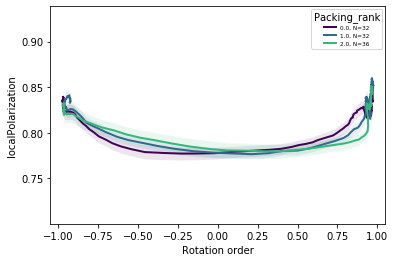

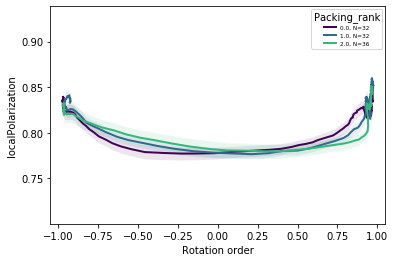

In [55]:
plot_data_vs_R(localrotrank, col='localPolarization', grouping='Packing_rank')

In [60]:
list(localrotrank.columns)

['Timestamp',
 'speed',
 'dir',
 'coh',
 'mean_polarization',
 'mean_radius',
 'median_radius',
 'median_swimSpeed',
 'median_dRotation_cArea',
 'median_dRotation_cMass',
 'std_dRotation_cArea',
 'std_dRotation_cMass',
 'entropy_Ra',
 'syncTime',
 'trialID',
 'date',
 'groupsize',
 'frame',
 'Packing_rank',
 'NeighbourDist_rank',
 'localPolarization_rank',
 'PDcor_rank',
 'neighbourDist',
 'localArea',
 'localPackingFraction',
 'localMedianRotation',
 'localRscore',
 'localPolarization',
 'localPDcor',
 'localSpeedScore']

<IPython.core.display.Javascript object>


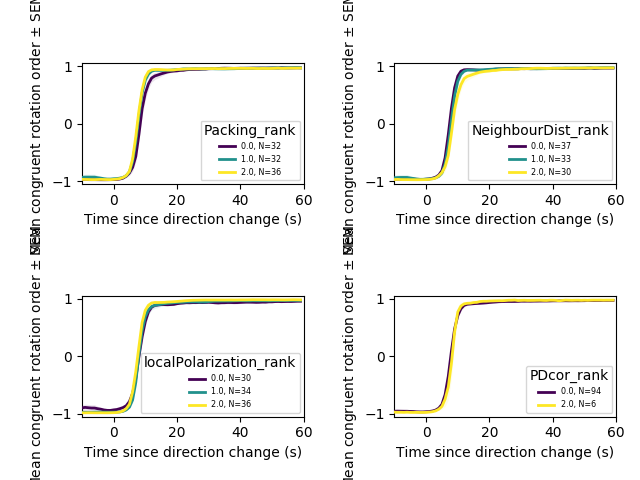

In [79]:
"""def plot_many_trials(trials, col='median_dRotation_cArea', grouping='trialID', plotTrials=True, 
                     fig= None, ax=None, colour=None, XLIM=(-10,60), YLIM=(-1.05,1.05), 
                     RESAMPLE='250ms', NORMALIZE_PRESTIM=False, 
                     YLABEL='Mean congruent rotation order $\pm$ SEM'):"""

ranks = ['Packing_rank',
         'NeighbourDist_rank',
         'localPolarization_rank',
         'PDcor_rank']
%matplotlib notebook
fig = plt.figure()
for i in range(len(ranks)):
    ax = fig.add_subplot(2,2,i+1)
    plot_many_trials(localrotrank, grouping=ranks[i], plotTrials=False,
                 XLIM=(-10,60), RESAMPLE='1s',fig=fig, ax=ax)
plt.tight_layout()
plt.savefig('/media/recnodes/Dan_storage/20200408_reversals_grouped_by_local_packing_fraction.svg')


In [64]:
plt.savefig('/media/recnodes/Dan_storage/20200408_reversals_grouped_by_local_packing_fraction.svg')

<Figure size 432x288 with 0 Axes>

<IPython.core.display.Javascript object>


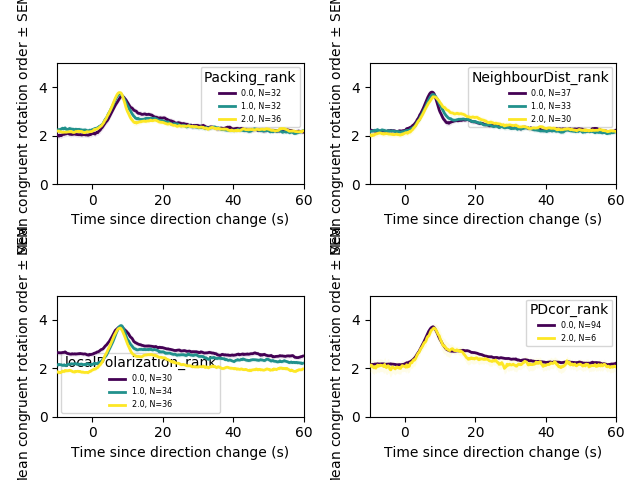

In [78]:
ranks = ['Packing_rank',
         'NeighbourDist_rank',
         'localPolarization_rank',
         'PDcor_rank']
%matplotlib notebook
fig = plt.figure()
for i in range(len(ranks)):
    ax = fig.add_subplot(2,2,i+1)
    plot_many_trials(localrotrank, col='entropy_Ra', grouping=ranks[i], plotTrials=False,
                 XLIM=(-10,60), YLIM=(0,5), fig=fig, ax=ax)
plt.tight_layout()
#plt.savefig('/media/recnodes/Dan_storage/20200408_reversals_grouped_by_local_packing_fraction.svg')


In [84]:
np.around(create_colourlist(6, 'viridis')*255,0)

array([[ 68.,   1.,  84., 255.],
       [ 65.,  68., 135., 255.],
       [ 42., 120., 142., 255.],
       [ 34., 168., 132., 255.],
       [122., 209.,  81., 255.],
       [253., 231.,  37., 255.]])